In [1]:
"""
TODO:
- Get at least a reasonable looking change. Maybe start with bad initial conditions.
- BFGS cannot handle constraints nor bounds
"""
import project_path
from model.neural_model import NeuralModel
import connectomes
import distance
import dynamics

import matplotlib.pyplot as plt
import numpy as np
import pdb

N = 3
simul_ts = 1500
eval_ts = 1000
dt = 0.01
simul_timepoints = np.arange(0, simul_ts * dt, dt)
eval_timepoints = np.arange((simul_ts - eval_ts)*dt, simul_ts * dt, dt)

# Golden dynamics

Total runtime = 0.13s


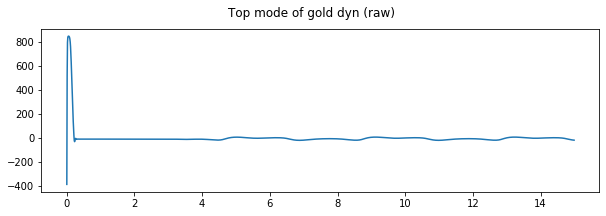

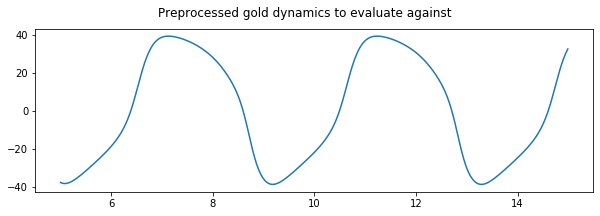

In [2]:
# Initial run
gold_dyn = dynamics.get_jimin_3neuron_dynamics(simul_ts, dt)
top_mode_gold_dyn = dynamics.get_top_mode(gold_dyn)
preprocessed_gold_dyn = distance.preprocess_pop_dyn(gold_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_gold_dyn)
fig.suptitle("Top mode of gold dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn)
fig.suptitle("Preprocessed gold dynamics to evaluate against")
_ = _

# Initial unoptimized dynamics

Total runtime = 0.16s
Initial error = 897.2250216636816


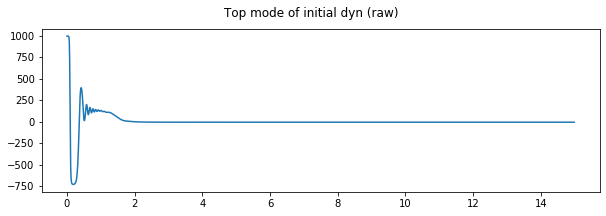

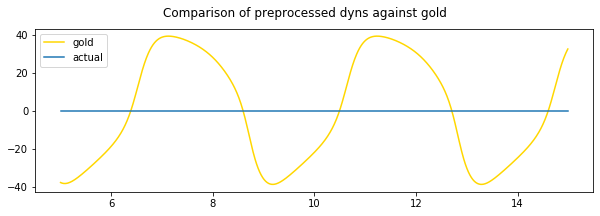

In [3]:
init_Gg, init_Gs, is_inhibitory = connectomes.get_random_connectome(N)
I_ext = dynamics.get_jimin_3neuron_Iext()
initial_dyn = dynamics.run_neural_model(N, init_Gg, init_Gs, is_inhibitory, I_ext, simul_ts, dt)

top_mode_initial_dyn = dynamics.get_top_mode(initial_dyn)
preprocessed_initial_dyn = distance.preprocess_pop_dyn(initial_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_initial_dyn)
fig.suptitle("Top mode of initial dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn, label="gold", c="gold")
ax.plot(eval_timepoints, preprocessed_initial_dyn, label="actual")
ax.legend()
fig.suptitle("Comparison of preprocessed dyns against gold")

error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_initial_dyn)
print("Initial error = " + str(error))
_ = _

# Perform optimization

In [4]:
def create_obj_fun(N, preprocessed_gold_dyn, eval_ts):
  def obj_fun(compact_vec):
    gg_mat, gs_mat = connectomes.compact_to_model_param(compact_vec, N)
    pop_dyn = dynamics.run_neural_model(N, gg_mat, gs_mat, is_inhibitory, I_ext, simul_ts, dt)
    preprocessed_pop_dyn = distance.preprocess_pop_dyn(pop_dyn, eval_ts)
    error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_pop_dyn)
    return error
  return obj_fun

In [11]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

init_cond_compact = connectomes.model_to_compact_param(init_Gg, init_Gs, N)
obj_fun = create_obj_fun(N, preprocessed_gold_dyn, eval_ts)
bnds = [(0, 10)] * (2 * N**2)

def optimize_with_bfgs():
  return minimize(obj_fun, init_cond_compact, method='BFGS', bounds=bnds, options={'maxiter':2})

def optimize_with_basin_hopping():
  minimizer_kwargs = {"method":"BFGS", "bounds":bnds}
  return basinhopping(obj_fun, init_cond_compact, minimizer_kwargs=minimizer_kwargs,
                      niter=1)
  
start_time = time.time()
res = optimize_with_bfgs()
print("Total optimization time = %.2fs" % (time.time() - start_time))
print(res)

/home/stephen/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


Total runtime = 0.21s
Total runtime = 0.12s
Total runtime = 0.13s
Total runtime = 0.17s
Total runtime = 0.13s
Total runtime = 0.13s
Total runtime = 0.14s
Total runtime = 0.13s
Total runtime = 0.14s
Total runtime = 0.13s
Total runtime = 0.14s


/home/stephen/Documents/code/optimization-playground/model/neural_model.py:103: RuntimeWarning: overflow encountered in exp
  phi = np.reciprocal(1.0 + np.exp(-self.B*(v_arr - self.Vth)))
/home/stephen/Documents/code/optimization-playground/model/neural_model.py:103: RuntimeWarning: overflow encountered in exp
  phi = np.reciprocal(1.0 + np.exp(-self.B*(v_arr - self.Vth)))


Total runtime = 0.25s
Total runtime = 0.32s


/home/stephen/Documents/code/optimization-playground/model/neural_model.py:103: RuntimeWarning: overflow encountered in exp
  phi = np.reciprocal(1.0 + np.exp(-self.B*(v_arr - self.Vth)))
/home/stephen/Documents/code/optimization-playground/model/neural_model.py:103: RuntimeWarning: overflow encountered in exp
  phi = np.reciprocal(1.0 + np.exp(-self.B*(v_arr - self.Vth)))


Total runtime = 0.26s
Total runtime = 0.29s


/home/stephen/Documents/code/optimization-playground/model/neural_model.py:103: RuntimeWarning: overflow encountered in exp
  phi = np.reciprocal(1.0 + np.exp(-self.B*(v_arr - self.Vth)))


Total runtime = 0.27s


/home/stephen/Documents/code/optimization-playground/model/neural_model.py:103: RuntimeWarning: overflow encountered in exp
  phi = np.reciprocal(1.0 + np.exp(-self.B*(v_arr - self.Vth)))


KeyboardInterrupt: 

In [10]:
new_Gg, new_Gs = connectomes.compact_to_model_param(res.x, N)
print("The optimized Gg and Gs are:\n%s\n%s" % (new_Gg, new_Gs))
print("Old Gg and Gs are:\n%s\n%s" % (init_Gg, init_Gs))


The optimized Gg and Gs are:
[[0.         0.6527003  0.31531931]
 [0.6527003  0.         0.99195441]
 [0.31531931 0.99195441 0.        ]]
[[0.         0.2905369  0.11972767]
 [0.73114958 0.         0.78674688]
 [0.84909276 0.45817415 0.        ]]
Old Gg and Gs are:
[[0.         0.6527003  0.31531931]
 [0.6527003  0.         0.99195441]
 [0.31531931 0.99195441 0.        ]]
[[0.         0.2905369  0.11972767]
 [0.73114958 0.         0.78674688]
 [0.84909276 0.45817415 0.        ]]


# Compare optimized dynamics against golden

Total runtime = 0.16s
Optimized error = 897.2250259413578


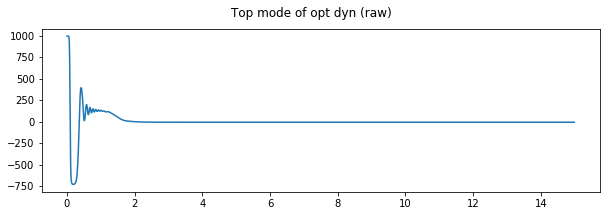

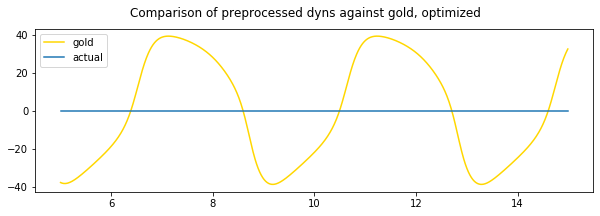

In [9]:
# Plot the optimized results

opt_dyn = dynamics.run_neural_model(N, new_Gg, new_Gs, is_inhibitory, I_ext, simul_ts, dt)

top_mode_opt_dyn = dynamics.get_top_mode(opt_dyn)
preprocessed_opt_dyn = distance.preprocess_pop_dyn(opt_dyn, eval_ts)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(simul_timepoints, top_mode_opt_dyn)
fig.suptitle("Top mode of opt dyn (raw)")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_timepoints, preprocessed_gold_dyn, label="gold", c="gold")
ax.plot(eval_timepoints, preprocessed_opt_dyn, label="actual")
ax.legend()
fig.suptitle("Comparison of preprocessed dyns against gold, optimized")

error = distance.ts_distance_euclidean(preprocessed_gold_dyn, preprocessed_opt_dyn)
print("Optimized error = " + str(error))
_ = _